In [1]:
# import libraries
import numpy as np
from scipy.stats import ttest_ind
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model

# analysis parameters
data_file = "GECC FYP Survey.csv"

In [2]:
# setup dataframe

# read file
raw_df = pd.read_csv(data_file, error_bad_lines=False)

'''
    rename columns to readable format
    activity_1 = join for student club / organization / student union
    activity_2 = exco for student club / organization / student union
'''
columns = [
    "time", 
    "gender", 
    "age", 
    "local_or_non_local", 
    "nationality_current", # voided
    "university", 
    "current_study", 
    "year_of_study", 
    "drinking_frequency", 
    "drinking_consumption_amount", 
    "drinking_frequency_six_servings", 
    "type_of_drink",
    "drinking_occasion", 
    "attention_test", 
    "drinking_frequency_before_examination", 
    "gpa", 
    "activity_1", 
    "activity_2", 
    "academic_achievements", 
    "professional_examinations", 
    "nationality_extra" # voided
    # nationality
]

raw_df.columns = columns

# fix nationality columns
raw_df["nationality"] = raw_df.nationality_current.combine_first(raw_df.nationality_extra)
raw_df.loc[ raw_df["nationality"] == "Malaysian 馬來西亞", "nationality" ] = "Malaysia"
raw_df.loc[ raw_df["nationality"] == "Philippine 菲律賓", "nationality" ] = "Philipine"
raw_df.loc[ raw_df["nationality"] == "Indonesian 印尼", "nationality" ] = "Indonesia"
raw_df.drop(columns=["nationality_current", "nationality_extra"], inplace=True)

df = raw_df.copy()

# filter based on valid response
df = df.loc[ df["attention_test"] == "Italian 義式" ]
df = df.loc[ df["gpa"] > 1 ]
df = df.loc[ (df.drinking_consumption_amount == 0) | ~(df.drinking_frequency == "Never 從來不飲用") ]
df = df.loc[ ~(df["university"] == "UCL") ]
df = df.loc[ df["current_study"] == "Undergraduate student 本科生" ]

# drop unnecessary columns
df.drop(columns=["time", "attention_test"], inplace=True)

df.head()


/opt/anaconda3/envs/gecc-fyp/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,gender,age,local_or_non_local,university,current_study,year_of_study,drinking_frequency,drinking_consumption_amount,drinking_frequency_six_servings,type_of_drink,drinking_occasion,drinking_frequency_before_examination,gpa,activity_1,activity_2,academic_achievements,professional_examinations,nationality
1,Male 男性,20,Non-local student 非本地生,The Chinese University of Hong Kong (CUHK) 香港中文大學,Undergraduate student 本科生,4 or above 四年級以上,Monthly or less 少於每月,7.0,Less than once per month 少於每月,Soju 燒酒,"Special events (birthdays, graduation, etc.) 特...",Never (0%) 從來不會,3.67,Yes 有,Yes 有,6,0.0,Philipine
2,Male 男性,21,Non-local student 非本地生,The Chinese University of Hong Kong (CUHK) 香港中文大學,Undergraduate student 本科生,4 or above 四年級以上,2-4 times a month 每月二至四次,3.0,Less than once per month 少於每月,Soju 燒酒,"Special events (birthdays, graduation, etc.) 特...",Never (0%) 從來不會,3.33,Yes 有,Yes 有,5,0.0,Indonesia
4,Male 男性,21,Non-local student 非本地生,The Chinese University of Hong Kong (CUHK) 香港中文大學,Undergraduate student 本科生,4 or above 四年級以上,2-4 times a month 每月二至四次,2.0,Less than once per month 少於每月,Soju 燒酒,"Special events (birthdays, graduation, etc.) 特...",Never (0%) 從來不會,3.55,Yes 有,No 沒有,4,0.0,Indonesia
5,Female 女性,21,Non-local student 非本地生,The Chinese University of Hong Kong (CUHK) 香港中文大學,Undergraduate student 本科生,4 or above 四年級以上,2-4 times a month 每月二至四次,3.0,Less than once per month 少於每月,Cocktails,"Special events (birthdays, graduation, etc.) 特...",Never (0%) 從來不會,3.50,Yes 有,No 沒有,6,0.0,Indonesia
6,Male 男性,20,Non-local student 非本地生,The Chinese University of Hong Kong (CUHK) 香港中文大學,Undergraduate student 本科生,4 or above 四年級以上,2-3 times a week 每週二至三次,3.0,Weekly 每週,Whiskey 威士忌,"Special events (birthdays, graduation, etc.) 特...",Occasionally (20%) 偶爾,3.60,Yes 有,No 沒有,2,0.0,Taiwan


In [3]:
print("Original Data :", len(raw_df))
print("Valid Data    :", len(df))

Original Data : 198
Valid Data    : 141


In [4]:
df.groupby("gender").size().reset_index()

,gender,0
0,Female 女性,67
1,Male 男性,72
2,Prefer not to say 不方便透露,2


In [5]:
df_groupby_local_nonlocal = df.groupby("local_or_non_local").size().reset_index()
df_groupby_local_nonlocal.columns = ["local_or_non_local", "size"]
df_groupby_local_nonlocal["percentage"] = df_groupby_local_nonlocal["size"] / df_groupby_local_nonlocal["size"].sum() * 100
df_groupby_local_nonlocal

,local_or_non_local,size,percentage
0,Local student 本地生,65,46.099291
1,Non-local student 非本地生,76,53.900709


In [6]:
data_groupby_countries = df.groupby("nationality").size().reset_index()
data_groupby_countries.columns = ["country", "size"]

data_groupby_countries["percentage"] = data_groupby_countries["size"] / data_groupby_countries["size"].sum() * 100

data_groupby_countries.sort_values(["size"], ascending=True, inplace=True)
data_groupby_countries

,country,size,percentage
7,Philipine,1,0.709220
8,Russia,1,0.709220
4,Kazakhstan,2,1.418440
6,Malaysia,2,1.418440
11,United States,2,1.418440
10,Thailand,4,2.836879
2,India,6,4.255319
0,China,9,6.382979
5,"Korea, South",10,7.092199
9,Taiwan,15,10.638298


In [7]:
data_groupby_university = df.groupby("university").size().reset_index()
data_groupby_university.columns = ["university", "size"]

data_groupby_university["percentage"] = data_groupby_university["size"] / data_groupby_university["size"].sum() * 100

data_groupby_university.sort_values(["size"], ascending=True, inplace=True)
data_groupby_university

,university,size,percentage
1,Lingnan University 嶺南大學,1,0.709220
4,The Hang Seng University of Hong Kong,1,0.709220
3,The Education University of Hong Kong (EduU) 香...,3,2.127660
0,City University of Hong Kong (CityU) 香港城市大學,7,4.964539
5,The Hong Kong Polytechnic University (PolyU) 香...,7,4.964539
6,The Hong Kong University of Science and Techno...,13,9.219858
7,The University of Hong Kong (HKU) 香港大學,18,12.765957
2,The Chinese University of Hong Kong (CUHK) 香港中文大學,91,64.539007


In [8]:
df.groupby('current_study').size().reset_index()

,current_study,0
0,Undergraduate student 本科生,141


In [9]:
df_groupby_year_of_study = df.groupby("year_of_study").size().reset_index()
df_groupby_year_of_study.columns = ["year_of_study", "size"]

df_groupby_year_of_study["percentage"] = df_groupby_year_of_study["size"] / df_groupby_year_of_study["size"].sum() * 100

df_groupby_year_of_study.sort_values(["size"], ascending=True, inplace=True)
df_groupby_year_of_study

,year_of_study,size,percentage
0,1,4,2.836879
1,2,26,18.439716
2,3,43,30.496454
3,4 or above 四年級以上,68,48.226950


In [10]:
df_groupby_drinks = df.groupby("type_of_drink").size().reset_index()
df_groupby_drinks.columns = ["type_of_drink", "size"]
df_groupby_drinks.sort_values("size", ascending=True, inplace=True)
df_groupby_drinks["percentage"] = df_groupby_drinks["size"] / df_groupby_drinks.loc[ 
    ~(df_groupby_drinks["type_of_drink"] == "I don't consume alcoholic beverage 我不飲用含酒精的飲料") 
]["size"].sum() * 100
df_groupby_drinks.loc[ 
    df_groupby_drinks["type_of_drink"] == "I don't consume alcoholic beverage 我不飲用含酒精的飲料", "percentage"
] = np.nan
df_groupby_drinks

,type_of_drink,size,percentage
0,Apple cider,1,0.884956
14,果酒,1,0.884956
13,wine,1,0.884956
12,cocktails but no particular preference for the...,1,0.884956
11,Wine,1,0.884956
15,水果酒,1,0.884956
16,香檳,1,0.884956
5,Gin,1,0.884956
4,Cocktails,1,0.884956
3,Cocktail,1,0.884956


In [11]:
df.groupby("type_of_drink").mean().reset_index().sort_values("gpa", ascending=False)

,type_of_drink,age,drinking_consumption_amount,gpa,academic_achievements,professional_examinations
12,cocktails but no particular preference for the...,22.000000,1.000000,3.620000,2.000000,0.000000
11,Wine,19.000000,1.500000,3.600000,1.000000,0.000000
14,果酒,20.000000,1.000000,3.500000,2.000000,0.000000
4,Cocktails,21.000000,3.000000,3.500000,6.000000,0.000000
6,I don't consume alcoholic beverage 我不飲用含酒精的飲料,20.785714,0.035714,3.493321,3.000000,0.357143
2,Cider,19.000000,1.000000,3.475000,4.000000,0.000000
10,Whiskey 威士忌,20.750000,4.850000,3.449333,3.416667,0.166667
0,Apple cider,19.000000,1.000000,3.400000,2.000000,0.000000
3,Cocktail,22.000000,0.030000,3.400000,2.000000,0.000000
15,水果酒,19.000000,1.000000,3.400000,0.000000,0.000000


In [12]:
drinking_occasions = {}

for index, record in df["drinking_occasion"].items():
    occasions = record.split(";")

    for occasion in occasions:
        if occasion in drinking_occasions:
            drinking_occasions[occasion] += 1
        else:
            drinking_occasions[occasion] = 1

df_groupby_occasions = pd.DataFrame(list(drinking_occasions.items()))
df_groupby_occasions.columns = ["occasion", "size"]
df_groupby_occasions.sort_values("size", ascending=True, inplace=True)

df_groupby_occasions["percentage"] = df_groupby_occasions["size"] / len(df.loc[ 
    ~(df["drinking_occasion"] == "I don't consume alcoholic beverage 我不飲用含酒精的飲料") 
]) * 100

df_groupby_occasions.loc[ 
    df_groupby_occasions["occasion"] == "I don't consume alcoholic beverage 我不飲用含酒精的飲料", "percentage"
] = np.nan

df_groupby_occasions

,occasion,size,percentage
6,Nil,1,0.869565
7,做paper,1,0.869565
8,at home with gf,1,0.869565
4,Drinking alone 單獨飲酒,20,17.391304
5,I don't consume alcoholic beverage 我不飲用含酒精的飲料,28,NaN
3,Family gatherings 家庭聚會,32,27.826087
2,Networking or career-related events 社交或工作相關的場合,36,31.304348
0,"Special events (birthdays, graduation, etc.) 特...",79,68.695652
1,Socialising with friends (dorm/student club ev...,92,80.000000


In [13]:
df_groupby_freq = df.groupby("drinking_frequency").size().reset_index()
df_groupby_freq.columns = ["drinking_frequency", "size"]
df_groupby_freq["percentage"] = df_groupby_freq["size"] / df_groupby_freq["size"].sum() * 100
df_groupby_freq

,drinking_frequency,size,percentage
0,2-3 times a week 每週二至三次,16,11.347518
1,2-4 times a month 每月二至四次,49,34.751773
2,4 or more times a week 每週四次以上,1,0.709220
3,Monthly or less 少於每月,48,34.042553
4,Never 從來不飲用,27,19.148936


In [14]:
df_groupby_six_freq = df.groupby("drinking_frequency_six_servings").size().reset_index()
df_groupby_six_freq.columns = ["drinking_frequency_six_servings", "size"]
df_groupby_six_freq["percentage"] = df_groupby_six_freq["size"] / df_groupby_six_freq["size"].sum() * 100
df_groupby_six_freq

,drinking_frequency_six_servings,size,percentage
0,Daily or almost daily 每天或幾乎每天,1,0.709220
1,Less than once per month 少於每月,48,34.042553
2,Monthly 每月,15,10.638298
3,Never 從來不會,65,46.099291
4,Weekly 每週,12,8.510638


In [15]:
df_groupby_bef_exam_freq = df.groupby("drinking_frequency_before_examination").size().reset_index()
df_groupby_bef_exam_freq.columns = ["drinking_frequency_before_examination", "size"]
df_groupby_bef_exam_freq["percentage"] = df_groupby_bef_exam_freq["size"] / df_groupby_bef_exam_freq["size"].sum() * 100
df_groupby_bef_exam_freq

,drinking_frequency_before_examination,size,percentage
0,Never (0%) 從來不會,104,73.758865
1,Occasionally (20%) 偶爾,28,19.858156
2,Often (60%) 經常,2,1.418440
3,Sometimes (40%) 有時,6,4.255319
4,Usually (80%) 通常,1,0.709220


# Calculating Risk Factor

In [16]:
def classification_drinking_consumption_amount_score(serving):
    if serving <= 2:
        return 0
    elif serving <= 4:
        return 1
    elif serving <= 6:
        return 2
    elif serving <= 9:
        return 3
    else:
        return 4


def classification_drinking_frequency_score(frequency):
    classification = {
        "Never 從來不飲用": 0,
        "Monthly or less 少於每月": 1,
        "Monthly or less 少於一個月": 1,
        "2-4 times a month 每月二至四次": 2,
        "2-3 times a week 每週二至三次": 3,
        "4 or more times a week 每週四次以上": 4
    }
    return classification[frequency]


def classification_drinking_frequency_six_servings_score(frequency):
    classification = {
        "Never 從來不會": 0,
        "Less than once per month 少於一個月": 1,
        "Less than once per month 少於每月": 1,
        "Monthly 每月": 2,
        "Weekly 每週": 3,
        "Daily or almost daily 每天或幾乎每天": 4
    }
    return classification[frequency]


def classification_drinking_frequency_before_examination_score(frequency):
    classification = {
        "Never (0%) 從來不會": 0,
        "Occasionally (20%) 偶爾": 1,
        "Sometimes (40%) 有時": 2,
        "Often (60%) 經常": 3,
        "Usually (80%) 通常": 4,
        "Always (100%) 總是": 5
    }
    return classification[frequency]

def classification_risk_score_category(score):
    if score < 3:
        return "Non Risk"
    else:
        return "Risk"

df_quantified = df.copy()

df_quantified.loc[ df_quantified.year_of_study == "4 or above 四年級以上", "year_of_study" ] = 4.0

df_quantified.loc[ df_quantified.activity_1 == "Yes 有", "activity_1" ] = 1.0
df_quantified.loc[ df_quantified.activity_1 == "No 沒有", "activity_1" ] = 0

df_quantified.loc[ df_quantified.activity_2 == "Yes 有", "activity_2" ] = 1.0
df_quantified.loc[ df_quantified.activity_2 == "No 沒有", "activity_2" ] = 0

df_quantified = df_quantified.assign(drinking_consumption_amount_score=df_quantified.drinking_consumption_amount.apply(classification_drinking_consumption_amount_score)) 
df_quantified = df_quantified.assign(drinking_frequency_score=df_quantified.drinking_frequency.apply(classification_drinking_frequency_score))
df_quantified = df_quantified.assign(drinking_frequency_six_servings_score=df_quantified.drinking_frequency_six_servings.apply(classification_drinking_frequency_six_servings_score))
df_quantified = df_quantified.assign(drinking_frequency_before_examination_score=df_quantified.drinking_frequency_before_examination.apply(classification_drinking_frequency_before_examination_score))
df_quantified = df_quantified.assign(
    audit_score=(df_quantified.drinking_consumption_amount_score + 
                df_quantified.drinking_frequency_score + 
                df_quantified.drinking_frequency_six_servings_score
                # df_quantified.drinking_frequency_before_examination_score
    )
)

In [17]:
df_quantified.year_of_study = pd.to_numeric(df_quantified.year_of_study)
df_quantified.drinking_frequency_score = pd.to_numeric(df_quantified.drinking_frequency_score)
df_quantified.drinking_consumption_amount_score = pd.to_numeric(df_quantified.drinking_consumption_amount_score)
df_quantified.drinking_frequency_six_servings_score = pd.to_numeric(df_quantified.drinking_frequency_six_servings_score)
df_quantified.drinking_frequency_before_examination_score = pd.to_numeric(df_quantified.drinking_frequency_before_examination_score)
df_quantified.activity_1 = pd.to_numeric(df_quantified.activity_1)
df_quantified.activity_2 = pd.to_numeric(df_quantified.activity_2)

df_quantified.head()

,gender,age,local_or_non_local,university,current_study,year_of_study,drinking_frequency,drinking_consumption_amount,drinking_frequency_six_servings,type_of_drink,...,activity_1,activity_2,academic_achievements,professional_examinations,nationality,drinking_consumption_amount_score,drinking_frequency_score,drinking_frequency_six_servings_score,drinking_frequency_before_examination_score,audit_score
1,Male 男性,20,Non-local student 非本地生,The Chinese University of Hong Kong (CUHK) 香港中文大學,Undergraduate student 本科生,4.0,Monthly or less 少於每月,7.0,Less than once per month 少於每月,Soju 燒酒,...,1.0,1.0,6,0.0,Philipine,3,1,1,0,5
2,Male 男性,21,Non-local student 非本地生,The Chinese University of Hong Kong (CUHK) 香港中文大學,Undergraduate student 本科生,4.0,2-4 times a month 每月二至四次,3.0,Less than once per month 少於每月,Soju 燒酒,...,1.0,1.0,5,0.0,Indonesia,1,2,1,0,4
4,Male 男性,21,Non-local student 非本地生,The Chinese University of Hong Kong (CUHK) 香港中文大學,Undergraduate student 本科生,4.0,2-4 times a month 每月二至四次,2.0,Less than once per month 少於每月,Soju 燒酒,...,1.0,0.0,4,0.0,Indonesia,0,2,1,0,3
5,Female 女性,21,Non-local student 非本地生,The Chinese University of Hong Kong (CUHK) 香港中文大學,Undergraduate student 本科生,4.0,2-4 times a month 每月二至四次,3.0,Less than once per month 少於每月,Cocktails,...,1.0,0.0,6,0.0,Indonesia,1,2,1,0,4
6,Male 男性,20,Non-local student 非本地生,The Chinese University of Hong Kong (CUHK) 香港中文大學,Undergraduate student 本科生,4.0,2-3 times a week 每週二至三次,3.0,Weekly 每週,Whiskey 威士忌,...,1.0,0.0,2,0.0,Taiwan,1,3,3,1,7


In [18]:
attribute_correlation = df_quantified.corr(method='pearson')

col_corr = ["gpa", "activity_1", "activity_2", "academic_achievements", "professional_examinations"]
row_corr = ["drinking_frequency_score", "drinking_consumption_amount_score", "drinking_frequency_six_servings_score"]

correlation_drinking_academic_achievement = attribute_correlation.loc[row_corr, col_corr]
correlation_drinking_academic_achievement.columns = [
    "GPA", "*Activity 1", "*Activity 2", "Awards/Scholarships", "Prof. Examinations"
]
correlation_drinking_academic_achievement.index = [
    "Drinking Freq.", "Drinking Amount", "Drinking Six Servings Freq."
]
correlation_drinking_academic_achievement[["GPA","Awards/Scholarships", "Prof. Examinations", "*Activity 1", "*Activity 2"]]

,GPA,Awards/Scholarships,Prof. Examinations,*Activity 1,*Activity 2
Drinking Freq.,-0.261822,-0.111228,-0.154665,0.169228,-0.019052
Drinking Amount,-0.232752,-0.024483,-0.109718,0.064169,0.018418
Drinking Six Servings Freq.,-0.221496,-0.109341,-0.096746,0.142393,-0.062162


In [19]:
df_quantified = df_quantified.assign(audit_score_category=df_quantified.audit_score.apply(classification_risk_score_category))
df_quantified.groupby("audit_score_category").size().reset_index()

,audit_score_category,0
0,Non Risk,68
1,Risk,73


# Hypothesis Testing (Non Risk vs. Risk Drinker)
Hypothesis testing using z value since sample size is assumed to be large and the level of significance will be 5%

$H_0$: average gpa of Non Risk and Risk Drinker are similar

$H_1$: average gpa of Non Risk and Risk Drinker are different

since significance level is 5%, the z-score that is expected to satisfied the null hyphothesis should be $\pm$ 1.96 (two-tailed test critical value), where the z-score can be calculated as follow:

Z-score formula in z-Test:
$$
    Z = \frac{X-\bar{X}}{\sqrt{\frac{S_1^2}{n_1} + \frac{S_2^2}{n_2}}}
$$

t-score formula in t-test:
$$
    s_p^2 = \frac{((n_1-1)s_1^2) + ((n_2-1)s_2^2)}{n_1 + n_2 - 2} \\[.3in]
    t = \frac{(\bar{X_1} - \bar{X_2})}{s_p \sqrt{\frac{1}{n_1} + \frac{1}{n_2}}}
$$

In [20]:
df_risk_drinker = df_quantified.loc[ df_quantified["audit_score_category"] == "Risk" ]
df_non_risk_drinker = df_quantified.loc[ df_quantified["audit_score_category"] == "Non Risk" ]

In [34]:
print(df_risk_drinker["gpa"].mean())
print(df_non_risk_drinker["gpa"].mean())

3.3063698630136984
3.4599999999999995


In [21]:
gpa_mean_risk_category = ttest_ind(df_non_risk_drinker['gpa'], df_risk_drinker['gpa'])
gpa_mean_risk_category

Ttest_indResult(statistic=3.144703573255622, pvalue=0.0020334256377796786)

In [35]:
print(df_risk_drinker["academic_achievements"].mean())
print(df_non_risk_drinker["academic_achievements"].mean())

2.136986301369863
2.485294117647059


In [22]:
awards_scholarships_mean_risk_category = ttest_ind(df_non_risk_drinker['academic_achievements'], df_risk_drinker['academic_achievements'])
awards_scholarships_mean_risk_category

Ttest_indResult(statistic=0.5599265471118787, pvalue=0.5764307753314899)

In [36]:
print(df_risk_drinker["professional_examinations"].mean())
print(df_non_risk_drinker["professional_examinations"].mean())

0.0684931506849315
0.3235294117647059


In [23]:
professional_examinations_mean_risk_category = ttest_ind(df_non_risk_drinker['professional_examinations'], df_risk_drinker['professional_examinations'])
professional_examinations_mean_risk_category

Ttest_indResult(statistic=2.109315468751657, pvalue=0.036710219786796935)

# Analysing Chart

3.493813518663802
[-0.12625878 -0.14310631 -0.06004328 -0.29061231]


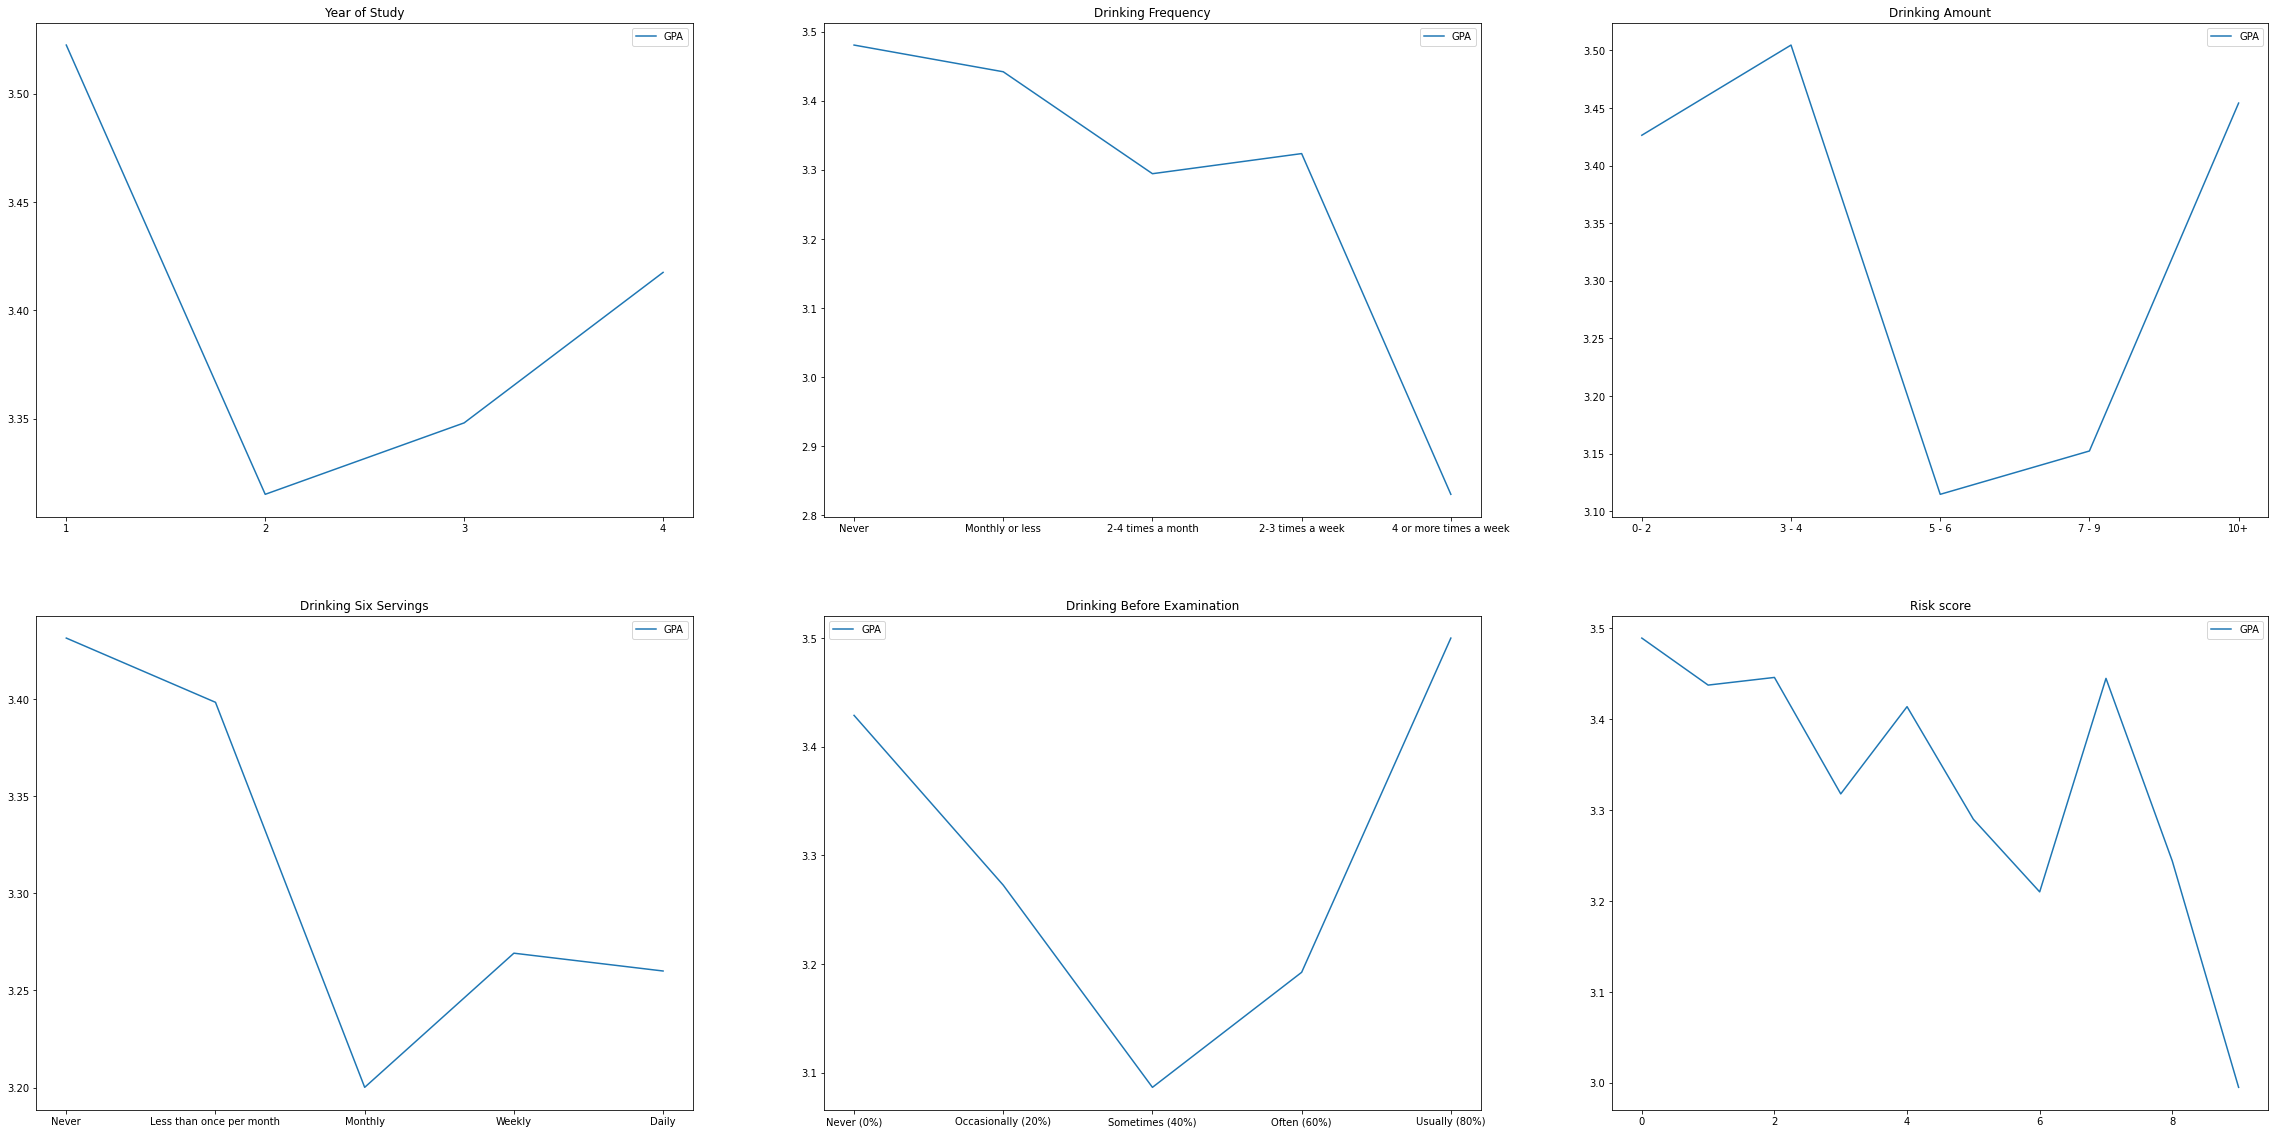

In [24]:
regression_attribute = [
    "year_of_study", "drinking_frequency_score", "drinking_consumption_amount_score", "drinking_frequency_six_servings_score", "drinking_frequency_before_examination_score", "audit_score", 
    "gpa", "activity_1", "activity_2", "academic_achievements", "professional_examinations"
]

df_quantified_regression = df_quantified[regression_attribute]
df_quantified_normalized = (df_quantified_regression - df_quantified_regression.min()) / (df_quantified_regression.max() - df_quantified_regression.min())

x_columns = ["drinking_frequency_score", "drinking_consumption_amount_score", "drinking_frequency_six_servings_score", "drinking_frequency_before_examination_score"]

# gpa
linear_regression_gpa = linear_model.LinearRegression()
linear_regression_gpa.fit(df_quantified_normalized[x_columns], df_quantified["gpa"])
print(linear_regression_gpa.intercept_)
print(linear_regression_gpa.coef_)

plt.figure(figsize=(40, 20))

# year of study
gpa_group_by_year = df_quantified[["year_of_study", "gpa"]].groupby("year_of_study").mean().reset_index()
plt_year = plt.subplot(2, 3, 1) 
plt_year.plot(gpa_group_by_year["year_of_study"], gpa_group_by_year["gpa"], label="GPA")
plt.title("Year of Study")
plt.legend()
plt.xticks([1, 2, 3, 4])

# freq
gpa_group_by_freq = df_quantified[["drinking_frequency_score", "gpa"]].groupby("drinking_frequency_score").mean().reset_index()
plt_freq = plt.subplot(2, 3, 2) 
plt_freq.plot([
    "Never",
    "Monthly or less",
    "2-4 times a month",
    "2-3 times a week",
    "4 or more times a week"
], gpa_group_by_freq["gpa"], label="GPA")
plt.title("Drinking Frequency")
plt.legend()


# amount
gpa_group_by_amount = df_quantified[["drinking_consumption_amount_score", "gpa"]].groupby("drinking_consumption_amount_score").mean().reset_index()
plt_amount = plt.subplot(2, 3, 3) 
plt_amount = plt.plot([
    "0- 2",
    "3 - 4",
    "5 - 6",
    "7 - 9",
    "10+"
], gpa_group_by_amount["gpa"], label="GPA")
plt.title("Drinking Amount")
plt.legend()

# drinking_frequency_six_servings
gpa_group_by_six_servings = df_quantified[["drinking_frequency_six_servings_score", "gpa"]].groupby("drinking_frequency_six_servings_score").mean().reset_index()
plt_six_servings = plt.subplot(2, 3, 4) 
plt_six_servings = plt.plot([
        "Never",
        "Less than once per month",
        "Monthly",
        "Weekly",
        "Daily"
], gpa_group_by_six_servings["gpa"], label="GPA")
plt.title("Drinking Six Servings")
plt.legend()

# Drinking frequency before exam
gpa_group_drinking_before_exam = df_quantified[["drinking_frequency_before_examination_score", "gpa"]].groupby("drinking_frequency_before_examination_score").mean().reset_index()
plt_before_exam = plt.subplot(2, 3, 5) 
plt_before_exam = plt.plot([
        "Never (0%)",
        "Occasionally (20%)",
        "Sometimes (40%)",
        "Often (60%)",
        "Usually (80%)",
], gpa_group_drinking_before_exam["gpa"], label="GPA")
plt.title("Drinking Before Examination")
plt.legend()

# Risk score
gpa_group_by_risk_score = df_quantified[["audit_score", "gpa"]].groupby("audit_score").mean().reset_index()
plt_risk_score = plt.subplot(2, 3, 6) 
plt_risk_score = plt.plot(gpa_group_by_risk_score["audit_score"], gpa_group_by_risk_score["gpa"], label="GPA")
plt.title("Risk score")
plt.legend()

plt.show()

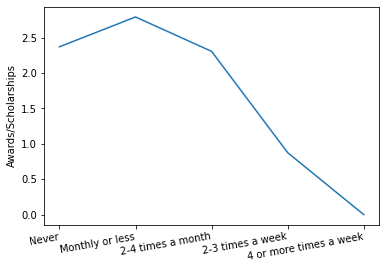

In [25]:
academic_acheievements_group_by_freq = df_quantified[["drinking_frequency_score", "academic_achievements"]].groupby("drinking_frequency_score").mean().reset_index()

plt.plot([
    "Never",
    "Monthly or less",
    "2-4 times a month",
    "2-3 times a week",
    "4 or more times a week"
], academic_acheievements_group_by_freq["academic_achievements"], label="Academic Acheievements")
# plt.xlabel("Drinking Frequency")
plt.ylabel("Awards/Scholarships")
plt.xticks(rotation=10, ha="right")
plt.savefig('out-aa.png', dpi=300)
# plt.legend()

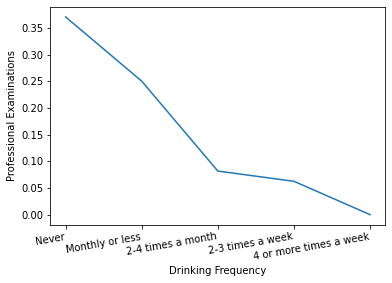

In [26]:
professional_examinations_group_by_freq = df_quantified[["drinking_frequency_score", "professional_examinations"]].groupby("drinking_frequency_score").mean().reset_index()
plt.plot([
    "Never",
    "Monthly or less",
    "2-4 times a month",
    "2-3 times a week",
    "4 or more times a week"
], professional_examinations_group_by_freq["professional_examinations"], label="Professional Examinations")
# plt.title("Drinking Frequency")
plt.xticks(rotation=10, ha="right")
plt.ylabel("Professional Examinations")
plt.xlabel("Drinking Frequency")
plt.savefig('out-pe.png', dpi=300)
# plt.legend()

In [27]:
for gpa in list(gpa_group_by_risk_score["gpa"]):
    print(gpa, end=" ")

3.489346153846154 3.4376190476190476 3.4460476190476195 3.317888888888889 3.413875 3.29 3.2100714285714287 3.4450000000000003 3.2439999999999998 2.995 

In [28]:
# gpa_group_by_risk_score = df_quantified[["risk_score", "gpa"]].groupby("risk_score").mean().reset_index()
# plt_risk_score = plt.subplot(2, 3, 6) 
# plt_risk_score = plt.plot(gpa_group_by_risk_score["risk_score"], gpa_group_by_risk_score["gpa"], label="GPA")
# plt.title("Risk score")
# plt.legend()


risk_score_regression = linear_model.LinearRegression()
risk_score_regression.fit(gpa_group_by_risk_score[["audit_score"]], list(gpa_group_by_risk_score["gpa"]))
print(risk_score_regression.intercept_)
print(risk_score_regression.coef_)

3.499530655455655
[-0.0379213]


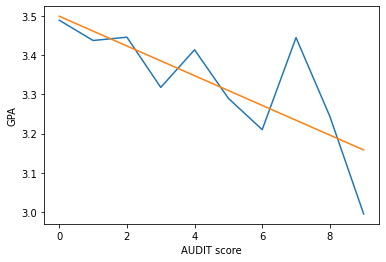

In [29]:
def risk_score_function(x):
    return risk_score_regression.intercept_ + x * risk_score_regression.coef_

gpa_group_by_risk_score = df_quantified[["audit_score", "gpa"]].groupby("audit_score").mean().reset_index()
plt.plot(gpa_group_by_risk_score["audit_score"], gpa_group_by_risk_score["gpa"], label="GPA")
plt.plot([0, 9], [risk_score_function(0), risk_score_function(9)])
plt.xlabel("AUDIT score")
plt.ylabel("GPA")
plt.savefig('out.png', dpi=300)
# plt.legend()

In [30]:
df_quantified[["drinking_consumption_amount", "gpa"]].describe().T[["mean", "std", "min", "max"]]

,mean,std,min,max
drinking_consumption_amount,2.903759,3.020992,0.000,15.000
gpa,3.380461,0.298931,2.649,3.998


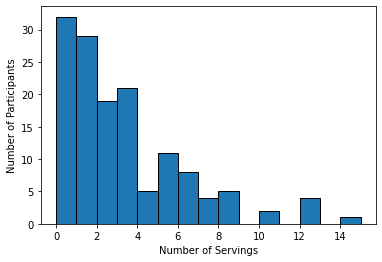

In [31]:
temp = df_quantified.groupby("drinking_consumption_amount").size().reset_index()
temp.columns = ["drinking_amount", "size"]
plt.hist(df_quantified["drinking_consumption_amount"], bins=15, edgecolor="black")
plt.ylabel("Number of Participants")
plt.xlabel("Number of Servings")
plt.savefig('out-da.png', dpi=300)
plt.show()

In [32]:
collection = {}
keys = []
import math
for drinking in list(df_quantified["drinking_consumption_amount"]):
    key = math.floor(drinking)
    # print(drinking, key)
    if key in collection:
        collection[key] += 1
    else:
        collection[key] = 1
        keys.append(key)

for key in sorted(keys):
    print(key, collection[key])

0 32
1 29
2 19
3 21
4 5
5 11
6 8
7 4
8 5
10 2
12 4
15 1
